In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import datetime as dt
from datetime import date

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect
from sqlalchemy import func
from sqlalchemy import Column, Integer, String, Float
from sqlalchemy import desc
from sqlalchemy.orm import sessionmaker, scoped_session
from flask import Flask,jsonify

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [8]:
#"inspect" delivers runtime information about a wide variety of SQLAlchemy objects
Inspect = inspect(engine)

In [9]:
#To get the table names, we use get_table_names function from inspect
Inspect.get_table_names()

['measurement', 'station']

In [10]:
#To get the column details, we use get_column function from inspect
columns_measurement = Inspect.get_columns('measurement')
for cols in columns_measurement:
    print(cols["name"], cols["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns_station = Inspect.get_columns('station')
for cols in columns_station:
    print(cols["name"], cols["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
Result = engine.execute("SELECT count(*) FROM Measurement").fetchall()
print(Result)

[(19550,)]


In [13]:
Result = engine.execute("SELECT count(*) FROM Station").fetchall()
print(Result)

[(9,)]


In [14]:
Result = engine.execute("SELECT count(*) FROM Measurement WHERE station is Null").fetchall()
print(Result)

[(0,)]


In [15]:
Result = engine.execute("SELECT count(*) FROM Measurement WHERE date is Null").fetchall()
print(Result)

[(0,)]


In [16]:
Result = engine.execute("SELECT count(*) FROM Measurement WHERE prcp is Null").fetchall()
print(Result)

[(0,)]


In [17]:
Result = engine.execute("SELECT count(*) FROM Measurement WHERE tobs is Null").fetchall()
print(Result)

[(0,)]


In [18]:
Result = engine.execute("SELECT count(*) FROM Station WHERE station is Null").fetchall()
print(Result)

[(0,)]


In [19]:
Result = engine.execute("SELECT count(*) FROM Station WHERE name is Null").fetchall()
print(Result)

[(0,)]


In [20]:
Result = engine.execute("SELECT count(*) FROM Station WHERE latitude is Null").fetchall()
print(Result)

[(0,)]


In [21]:
Result = engine.execute("SELECT count(*) FROM Station WHERE longitude is Null").fetchall()
print(Result)

[(0,)]


In [22]:
Result = engine.execute("SELECT count(*) FROM Station WHERE elevation is Null").fetchall()
print(Result)

[(0,)]


In [23]:
#Update the 'Measurement' table and subsitute the "prcp" with 0.0 where there is Null values or None values
engine.execute("Update Measurement SET prcp=0.0 WHERE prcp is NULL")

In [24]:
Result = engine.execute("SELECT count(*) FROM Measurement WHERE prcp is Null").fetchall()
print(Result)

[(0,)]


In [25]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Get the first element of the tuple
max_date = max_date[0]

# Calculate the date 1 year ago from the last data point in the database
# The days are equal 366 so that the first day of the year is included
year_ago = dt.datetime.strptime(max_date, "%Y-%m-%d") - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(query,columns=['date', 'precipitation'])

# Change datatype from element to datetime object on Pandas
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'], format='%Y-%m-%d')

# Set index to date
precipitation_df.set_index('date', inplace=True)

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date',ascending=True)
precipitation_df.head()


,precipitation
date,
2016-08-23,0.00
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


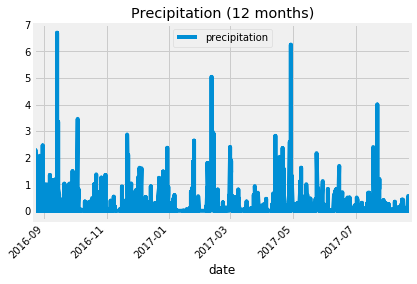

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

In [26]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(title="Precipitation (12 months)")
plt.legend(loc='upper center')
plt.xticks(rotation='45')
plt.show()
plt.tight_layout

#plt.savefig("Precipitation.pdf")


In [27]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


In [28]:
# Design a query to show how many stations are available in this dataset?
available_stations = session.query(Measurement.station).distinct().count()
print(f"Stations Available: {available_stations} ")

Stations Available: 9 


In [29]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, 
                                func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(f"Most Active Stations")
active_stations

Most Active Stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [30]:
# Finding most active station 
most_active_station=active_stations[0][0]
print(f"Most Active Station: {most_active_station}")

Most Active Station: USC00519281


In [31]:
results = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.date >= '2017-01-10').all()
print(results)

[(58.0, 87.0, 74.38272524199553)]


In [32]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
print(f"Most Active Station Temperatures")
print(f"Low: {most_active_temps[0][0]} High: {most_active_temps[0][1]} Average: {round(most_active_temps[0][2], 1)}")

Most Active Station Temperatures
Low: 54.0 High: 85.0 Average: 71.7


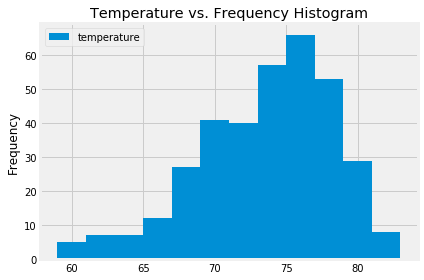

In [33]:
# Choose the station with the highest number of temperature observations.
most_temps_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
most_temps_station= most_temps_station[0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_observations = session.query( Measurement.tobs).filter(Measurement.date >= year_ago).filter(Measurement.station == most_temps_station).all()
temperature_observations = pd.DataFrame(temperature_observations, columns=['temperature'])

# We need 12 bins since the observation is for twelve months
temperature_observations.plot.hist(bins=12, title="Temperature vs. Frequency Histogram")
plt.tight_layout()
#plt.savefig('TemperaturevsFrequency.png')
plt.show()

In [34]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs),func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


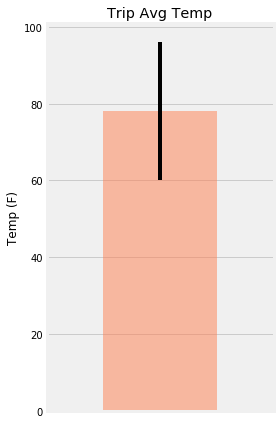

In [35]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps('2017-07-01','2017-07-14')
trip# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_temp_df = pd.DataFrame(trip, columns=['tmin', 'tavg', 'tmax'])

trip_temp_df.plot.bar(y='tavg', yerr=(trip_temp_df['tmax'] - trip_temp_df['tmin']), title='Trip Avg Temp', color='coral', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.show()

In [36]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def precipitation(start_date, end_date):
    
        # Docstring for the function `calc_temps`
    """Precipitation information per weather station
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        A list of tuples containing precipitation amount, station, name, latitude, longitude, and elevation in descending order.
    """
    
    sel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp]
    
    return session.query(*sel).\
            filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

print(precipitation('2017-07-01','2017-07-14'))

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.1), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.08), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.06), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.02), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


In [37]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [38]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date= '2012-02-28'
end_date='2012-03-05'

# Use the start and end date to create a range of dates
dates = session.query(Measurement.date).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.date).all()
trip_dates = [x[0] for x in dates]

# Stip off the year and save a list of %m-%d strings
trip_dates_stripped= [x[5:] for x in trip_dates]
start_month_day = trip_dates_stripped[0]
end_month_day = trip_dates_stripped[-1]


# Loop through the list of %m-%d strings and calculate the normals for each date

daily_normals = [session.query(func.min(Measurement.tobs),
                       func.avg(Measurement.tobs),
                       func.max(Measurement.tobs)).filter(func.strftime("%m-%d", Measurement.date) >= start_month_day).filter(func.strftime("%m-%d", Measurement.date) <= end_month_day).group_by(func.strftime("%m-%d", Measurement.date)).all()]

daily_normals = daily_normals[0]
print("Aggregate Daily Normals for 02-28 to 03-05")
daily_normals


Aggregate Daily Normals for 02-28 to 03-05


[(65.0, 70.65517241379311, 80.0),
 (67.0, 71.73333333333333, 79.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0)]

In [39]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
# Create a dataframe from the previous query 
daily_normals_df= pd.DataFrame(daily_normals,columns=['tmin', 'tavg', 'tmax'])

# Add trip_dates to Pandas DataFrame
daily_normals_df['date']= trip_dates

# Change datatype from element to datetime object on Pandas, makes x axis title to add 
daily_normals_df['date'] = pd.to_datetime(daily_normals_df['date'], format='%Y-%m-%d')

# Set index to date
daily_normals_df.set_index('date',inplace=True)

daily_normals_df

,tmin,tavg,tmax
date,,,
2012-02-28,65.0,70.655172,80.0
2012-02-29,67.0,71.733333,79.0
2012-03-01,64.0,70.032787,76.0
2012-03-02,61.0,70.366667,78.0
2012-03-03,60.0,70.068966,78.0
2012-03-04,57.0,69.272727,77.0
2012-03-05,60.0,67.890909,76.0


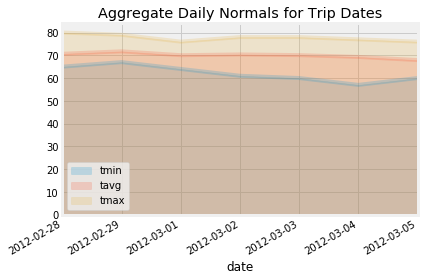

In [40]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot(kind='area', alpha=.2, stacked=False, x_compat=True, title="Aggregate Daily Normals for Trip Dates")
plt.tight_layout()
plt.show()